## Pandas analysis

This exercise consists in analyzing a dataset containg timing information from a series of Time-to-Digital-Converters (TDC) implemented in a couple of FPGAs. Each measurement (i.e. each row of the input file) consists of a flag that specifies the type of message ('HEAD', which in this case is always 1), two addresses of the TDC providing the signal ('FPGA' and 'TDC_CHANNEL'), and the timing information ('ORBIT_CNT', 'BX_COUNTER', and 'TDC_MEAS'). Each TDC count corresponds to 25/30 ns, whereas a unit of BX_COUNTER corresponds to 25 ns, and the ORBIT_CNT is increased every 'x' BX_COUNTER. This allows to store the time in a similar way to hours, minutes and seconds.

In [ ]:
# If you didn't download it yet, please get the relevant file now!
!wget https://www.dropbox.com/s/xvjzaxzz3ysphme/data_000637.txt -P ~/data/

1\. Create a Pandas DataFrame reading N rows of the 'data_000637.txt' dataset. Choose N to be smaller than or equal to the maximum number of rows and larger that 10k.

2\. Find out the number of BX in a ORBIT (the value 'x').

3\. Find out how much the data taking lasted. You can either make an estimate based on the fraction of the measurements (rows) you read, or perform this check precisely by reading out the whole dataset.

4\. Create a new column with the absolute time in ns (as a combination of the other three columns with timing information).

5\. Replace the values (all 1) of the HEAD column randomly with 0 or 1.

6\. Create a new DataFrame that contains only the rows with HEAD=1.

7\. Make two occupancy plots (one for each FPGA), i.e. plot the number of counts per TDC channel

8\. Use the groupby method to find out the noisy channels, i.e. the TDC channels with most counts (say the top 3)

9\. Count the number of unique orbits. Count the number of unique orbits with at least one measurement from TDC_CHANNEL=139

# Import the libraries


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1

In [5]:
#N = 50e3
df = pd.read_csv("/home/simone/data/data_000637.txt")#,nrows=N)
df

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS
0,1,0,123,3869200167,2374,26
1,1,0,124,3869200167,2374,27
2,1,0,63,3869200167,2553,28
3,1,0,64,3869200167,2558,19
4,1,0,64,3869200167,2760,25
...,...,...,...,...,...,...
1310715,1,0,62,3869211171,762,14
1310716,1,1,4,3869211171,763,11
1310717,1,0,64,3869211171,764,0
1310718,1,0,139,3869211171,769,0


# 2

In [3]:
j = 0
all_BX = np.empty(0)
for i in range(1,len(df)):
    if df['ORBIT_CNT'][i-1] != df['ORBIT_CNT'][i]: 
       # print(df['ORBIT_CNT'][i-1],df['ORBIT_CNT'][i])
        all_BX = np.append(all_BX, df['BX_COUNTER'][j:i].max() + 1)
        j = i
#print(all_BX)
# In some cases (like in orbit 3869200211 3869200212) the FPGA jump back an foward to the orbit, so i delete the BXCOUNTER <100
mask   = (all_BX>100)
all_BX = all_BX[mask]
x = df['BX_COUNTER'].max() +1

# 3 and 4

In [4]:
df['time [ns]']=df['TDC_MEAS']*(5./6.)+df['ORBIT_CNT']*(25.*x)+x*25.
# set zero the time of orbit one 
print ("Data taking lasted : ",round((df['time [ns]'][len(df)-1]-df['time [ns]'][0])*10**(-9),3), "s")

Data taking lasted :  0.98 s


# 5

In [5]:
s = np.random.randint(0,2,len(df))
df['HEAD'] = s

# 6

In [6]:
mask = (df['HEAD']==1)
df2  = df[mask]

In [20]:
df2

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,time [ns]
2,1,0,63,3869200167,2553,28,3.447457e+14
3,1,0,64,3869200167,2558,19,3.447457e+14
6,1,0,61,3869200167,2772,14,3.447457e+14
7,1,0,139,3869200167,2776,0,3.447457e+14
10,1,1,7,3869200167,2785,4,3.447457e+14
...,...,...,...,...,...,...,...
1310708,1,0,124,3869211171,199,9,3.447467e+14
1310711,1,1,39,3869211171,430,0,3.447467e+14
1310714,1,0,60,3869211171,762,2,3.447467e+14
1310715,1,0,62,3869211171,762,14,3.447467e+14


# 7

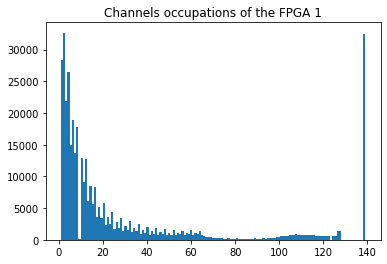

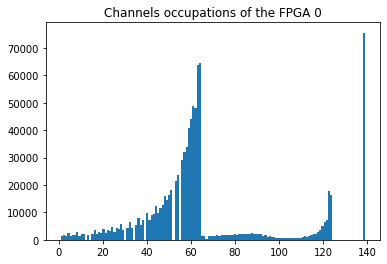

In [75]:
mask1 = (df['FPGA']==1)

plt.hist(df[mask1]['TDC_CHANNEL'],bins=df[mask1]['TDC_CHANNEL'].max())
plt.title('Channels occupations of the FPGA 1')
plt.show()

# using ~mask i get the complementary mask, so if mask1 contains the FPGA=1 the ~mask1 = FPGA 0
plt.hist(df[~mask1]['TDC_CHANNEL'],bins=df[~mask1]['TDC_CHANNEL'].max())
plt.title('Channels occupations of the FPGA 0')
plt.show()

9. Count the number of unique orbits. Count the number of unique orbits with at least one measurement from TDC_CHANNEL=139

# 8 

In [73]:
print("FPGA = 0 \n", df[~mask1].groupby(['TDC_CHANNEL']).FPGA.count().nlargest(3))
print("FPGA = 1 \n", df[mask1].groupby(['TDC_CHANNEL']).FPGA.count().nlargest(3))

FPGA = 0 : 
 TDC_CHANNEL
139    75617
64     64581
63     63724
Name: FPGA, dtype: int64
FPGA = 1 : 
 TDC_CHANNEL
2      32669
139    32442
1      28438
Name: FPGA, dtype: int64


# 9

In [6]:
# .unique() -> unique data in dataframe
print( "Numbers of unique orbits : " , len(df.ORBIT_CNT.unique()))
print("Number of unique orbits with at least one measurement in TDC_CHANNEL=139 : ", len(df[df['TDC_CHANNEL']==139].ORBIT_CNT.unique()))

Numbers of unique orbits :  11001
Number of unique orbits with at least one measurement in TDC_CHANNEL=139 :  10976
